## Bike Sharing Problem - Deep Learning

In [21]:
## Loading required package
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import scipy.stats as stats

# Sklearn metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

# Sklearn models
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Sklearn untility functions
from sklearn.model_selection import train_test_split

# XGBoost, Catboost, and LightGBM models
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
import lightgbm as lgbm

# Keras 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta, Adam, rmsprop

from sklearn.model_selection import train_test_split

# Beautify evaluation tables
from prettytable import PrettyTable

# Bayesian Optimization
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_evaluations
from skopt.plots import plot_objective
from skopt.plots import plot_convergence

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

np.random.seed(42)

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

Using TensorFlow backend.


In [3]:
# Cluster Inspection
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,10 hours 50 mins
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,1 month and 19 days
H2O cluster name:,H2O_from_python_chrisjcc_bzmk2p
H2O cluster total nodes:,1
H2O cluster free memory:,3.187 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [4]:
# File path 
base_dir = '/Users/chrisjcc/Downloads/'

data_path = base_dir + 'hour.csv'

In [5]:
# Load data
#data = h2o.import_file(data_path)
data = h2o.upload_file(data_path, destination_frame="train_frame")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
# Quick check of proper loading of dataset
data.head()

instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1,2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16
2,2011-01-01 00:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.8,0,8,32,40
3,2011-01-01 00:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.8,0,5,27,32
4,2011-01-01 00:00:00,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13
5,2011-01-01 00:00:00,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0,0,1,1
6,2011-01-01 00:00:00,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
7,2011-01-01 00:00:00,1,0,1,6,0,6,0,1,0.22,0.2727,0.8,0,2,0,2
8,2011-01-01 00:00:00,1,0,1,7,0,6,0,1,0.2,0.2576,0.86,0,1,2,3
9,2011-01-01 00:00:00,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0,1,7,8
10,2011-01-01 00:00:00,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0,8,6,14


In [7]:
data.summary()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
type,int,time,int,int,int,int,int,int,int,int,real,real,real,real,int,int,int
mins,1.0,1.29384e+12,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.02,0.0,0.0,0.0,0.0,0.0,1.0
mean,8690.0,1.32547731455e+12,2.50163991024,0.502560561597,6.53777547615,11.5467518269,0.0287703550262,3.00368260544,0.682720524771,1.425283388,0.496987168422,0.475775102135,0.627228839404,0.190097606306,35.6762184245,153.78686921,189.463087635
maxs,17379.0,1.356912e+12,4.0,1.0,12.0,23.0,1.0,6.0,1.0,4.0,1.0,1.0,1.0,0.8507,367.0,886.0,977.0
sigma,5017.02949961,18150225217.8,1.10691813945,0.500007829091,3.43877571375,6.91440509526,0.167165276384,2.00577145611,0.465430633524,0.639356877754,0.19255612125,0.171850215635,0.192929834063,0.122340228573,49.3050303871,151.357285913,181.387599092
zeros,0,0,0,8645,0,726,16879,2502,5514,0,0,2,22,2180,1581,24,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,2011-01-01 00:00:00,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,3.0,13.0,16.0
1,2.0,2011-01-01 00:00:00,1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.8,0.0,8.0,32.0,40.0
2,3.0,2011-01-01 00:00:00,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.8,0.0,5.0,27.0,32.0


In [8]:
print(data.names)

[u'instant', u'dteday', u'season', u'yr', u'mnth', u'hr', u'holiday', u'weekday', u'workingday', u'weathersit', u'temp', u'atemp', u'hum', u'windspeed', u'casual', u'registered', u'cnt']


In [9]:
data.set_names(['rec_id','datetime', 'season', 'year', 'month', 'hour', 'is_holiday', 
                'weekday', 'is_workingday', 'weather_condition', 'temp', 'atemp', 'humidity', 
                'windspeed', 'casual', 'registered', 'total_count'])

rec_id,datetime,season,year,month,hour,is_holiday,weekday,is_workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
1,2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16
2,2011-01-01 00:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.8,0,8,32,40
3,2011-01-01 00:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.8,0,5,27,32
4,2011-01-01 00:00:00,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13
5,2011-01-01 00:00:00,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0,0,1,1
6,2011-01-01 00:00:00,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
7,2011-01-01 00:00:00,1,0,1,6,0,6,0,1,0.22,0.2727,0.8,0,2,0,2
8,2011-01-01 00:00:00,1,0,1,7,0,6,0,1,0.2,0.2576,0.86,0,1,2,3
9,2011-01-01 00:00:00,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0,1,7,8
10,2011-01-01 00:00:00,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0,8,6,14


In [10]:
# Split the data into Train/Test/Validation with Train having 70% and test and validation 15% each
train, test, valid = data.split_frame(ratios=[.7, .15], 
                                      destination_frames=['train', 'test', 'valid'])

In [11]:
# Setting proper data types (i.e.categorical fetures)

# convert response column to a factor
train["season"].asfactor()

# date time conversion
pattern = "%m/%d/%Y %I:%M:%S %p"
train.as_date(pattern)

train['season'].asfactor()
train['is_holiday'].asfactor()
train['weekday'].asfactor()
train['weather_condition'].asfactor()
train['is_workingday'].asfactor()
train['month'].asfactor()
train['hour'].asfactor()
train['year'].asfactor()

year
0
0
0
0
0
0
0
0
0
0


In [12]:
predictors = ["season", "is_holiday", "weekday", "weather_condition", 
              "is_workingday", "month", "hour"]
response_col = "total_count"

In [13]:
print("We have %d training samples and %d test samples." % (train['total_count'].dim[0], 
                                                            test['total_count'].dim[0]))

We have 12181 training samples and 2584 test samples.


In [14]:
# Encoding all the categorical features
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month',#'year'
                ]

# though we have transformed all categoricals into their one-hot encodings, note that ordinal
# attributes such as hour, weekday, and so on do not require such encoding.
numeric_feature_cols = ['temp','humidity','windspeed', 'atemp',
                        'hour','weekday','month',#'year'
                       ]
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

In [15]:
# Simple Deep Learning - Predict Arrest
model_dl = H2ODeepLearningEstimator(distribution="poisson", #"gaussian", 
                                    variable_importances=True,
                                    categorical_encoding='one_hot_internal',
                                    loss="Automatic",
                                    activation = "rectifier", 
                                    hidden = [150, 150, 150], 
                                    epochs = 64
                                   )

model_dl.train(x=predictors, 
               y=response_col,
               training_frame   =train,
               #validation_frame=valid
              )

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [16]:
# Make prediction on test and training data set
y_pred = model_dl.predict(test)
y_res  = model_dl.predict(train)

deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


In [17]:
# Evaluate model performance (for shortness of time will only CV MAE)
mae = mean_absolute_error(test[response_col].as_data_frame(), 
                         y_pred['predict'].as_data_frame()
                        )
#mae = model_dl.mae(xval=True)

In [18]:
table = PrettyTable()
table.field_names = ["Model", 
                     "Dataset", 
                     "MAE", 
                    ]

In [19]:
table.add_row(['H2ODeepLearningEstimator', 
               'training',
               format(mae, '.2f'),
               ],
              )
print(table)

+--------------------------+----------+-------+
|          Model           | Dataset  |  MAE  |
+--------------------------+----------+-------+
| H2ODeepLearningEstimator | training | 65.69 |
+--------------------------+----------+-------+


## Model Optimization

### Bayesian optimization with BayesianOptimization

In [20]:
def train_model(#train,
                #x, # predictor labels,
                #y, # response label
                #x_train, y_train,
                #x_valid, y_valid,
                hidden=[150, 150, 150],
                activation='rectifier',
                rate=1e-5,
                #hidden_dropout_ratios=[0.2, 0.2]
               ):
    
    params = {
        'distribution': 'poisson', #"gaussian"
        'variable_importances': True,
        'categorical_encoding': 'one_hot_internal',
        'loss': 'Automatic',
        'hidden': hidden,           
        'activation': 'rectifier',
        'rate': rate,
        'epochs' : 64,
    }

    nn = h2o.estimators.deeplearning.H2ODeepLearningEstimator(nfolds=5,**params)
    
    #predictor_labels = list(set(x_train.names)-{"label"})
    #response_label = y_train.names[0]
    
    nn.train(x = predictors,
             y = response_col,
             training_frame = train,
             #validation_frame = valid
            )    
    #h2o_data = h2o.ls()
    #print(h2o_data)
    #h2o_data = list(h2o_data['key'])
    #h2o_data = list(filter(lambda x: x not in ["train_frame", "train", "test"], h2o_data))
    #list(map(lambda x: h2o.remove(x), h2o_data))

    metric = -nn.mae() # model.rmse()
    #metric = -nn.rmse()
    
    return metric

In [ ]:
# Bounded region of parameter space
pbounds = {
    #'train': (train), 
    #'x': (predictors), 
    #'y': (response_col),
    'rate': (1e-5, 1e-2)
    #'activation_list' : ('tanh', 'tanh_with_dropout', 'rectifier', 'rectifier_with_dropout', 'maxout'),  #Categorical
    #'hidden_list' : ([150, 150, 150], [100, 100, 100, 100])
}

In [ ]:
optimizer = BayesianOptimization(f=train_model,
                                 pbounds=pbounds,
                                 random_state=42,
                                 verbose=42)

In [ ]:
# Results will be saved in ./logs.json
logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTMIZATION_STEP, logger)

In [ ]:
load_logs(optimizer, logs=["./logs.json"]);

In [ ]:
optimizer.maximize(n_iter=10, init_points=2)

- n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
- init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.

In [ ]:
optimizer.max

In [ ]:
optimizer.max['params']

In [ ]:
optimizer.max['target']

In [ ]:
# And all the process in each step...(e.g. first step)
optimizer.res[0]

In [ ]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

### Bayesian optimization with Skopt

In [31]:
# define the space of hyperparameters to search
search_space = [Real(name='rate',
                     low=1e-5, high=1e-2, 
                     prior='uniform',  # 'log-uniform'
                     ),
                Categorical(name='activation', 
                            categories=['rectifier','tanh']),
                #Real(0.1, 0.5, name='dropout'),
                #Integer(1, 2, name='p'),
               ]

In [33]:
# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
    # Model
    model = h2o.estimators.deeplearning.H2ODeepLearningEstimator(nfolds=5, **params)
    model.set_params(** {'distribution': 'poisson', #"gaussian"
                         'variable_importances': True,
                         'categorical_encoding': 'one_hot_internal',
                         'loss': 'Automatic',
                         'hidden': [150, 150, 150],           
                         'activation': 'rectifier',
                         'epochs' : 64,
                         })
    
    # calculate 5-fold cross validation
    model.train(x = predictors,
                y = response_col,
                training_frame = train,
                #validation_frame = valid
                )
    
    # calculate the mean of the scores
    estimate = model.mae()
    
    return 1.0 - estimate

In [34]:
# perform optimization
result = gp_minimize(func=evaluate_model,      # the function to minimize
                     dimensions=search_space,  # the bounds on each dimension
                     acq_func='gp_hedge',      # the acquisition function
                     n_calls=10,               # the number of evaluations of f (e.g. 100)
                     random_state=42)          # the random seed

deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [35]:
# summarizing finding
print('Best MAE: %.3f' % (1.0 - result.fun))

Best MAE: 89.021


In [36]:
print("""Best parameters:
- rate=%.6f
""" % (result.x[0]))

Best parameters:
- rate=0.004464



In [41]:
print(result)

          fun: -88.02096297714978
    func_vals: array([-68.57208003, -72.03527722, -88.02096298, -67.89507861,
       -74.02633738, -72.4289914 , -83.53065581, -66.75804452,
       -74.45041407, -65.72622653])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=2, noise='gaussian', normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=1608637542)]
 random_state: <mtrand.RandomState object at 0x125f84e60>
        space: Space([Real(low=1e-05, high=0.01, prior='uniform', transform='normalize'),
       Categorical(categories=('rectifier', 'tanh'), prior=None)])
        specs: {'function': 'base_minimize', 'args': {'base_estimator': GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5),
             n_restarts_optimizer=2, noise='gaussian', normalize_y=True,
   

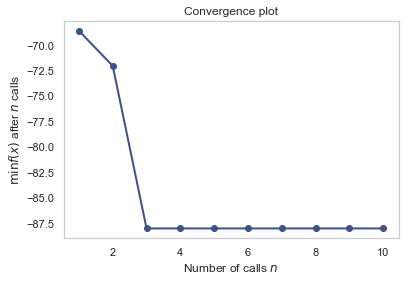

In [42]:
# Plot convergence traces
plot_convergence(result);

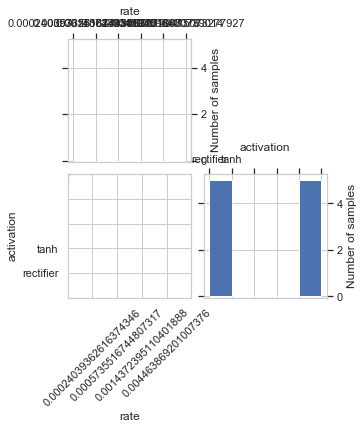

In [51]:
# Visualize the order in which points where sampled
plot_evaluations(result, bins=5, 
                 dimensions=['rate', 'activation'] # space.dimensions[-].name
                );

In [47]:
# Pairwise partial dependence plot of the objective function.
#plot_objective(result, 
#               dimensions=['rate', 'activation']
#              )

### Bayesian Optimization with hyperopt

In [62]:
# Set experiment
trials = Trials()

In [63]:
def objective(params):
    
    model = h2o.estimators.deeplearning.H2ODeepLearningEstimator(nfolds=5,**params)
    
    model.train(x = predictors,
                y = response_col,
                training_frame = train,
                )    

    metric = model.mae()

    return {'loss': -metric, 'status': STATUS_OK}

In [64]:
#hidden_list = [[150, 150, 150], [100, 100, 100, 100]]
#activation_list = ['tanh', 
                   #'tanh_with_dropout',
                   #'rectifier', 
                   #'rectifier_with_dropout',
                   #'maxout'
                   #]
loop = 2
max_loop = 2 #200

space = {
    'rate': hp.uniform('rate', 1e-5, 1e-2),
    #'hidden': hp.choice('hidden', hidden_list),
    #'activation': hp.choice('activation', activation_list),
}

In [65]:
best = fmin(objective, 
            space, 
            algo=tpe.suggest,
            max_evals=max_loop,
            trials=trials
           )

deeplearning Model Build progress: [
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#] 100%
deeplearning Model Build progress: [
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#] 100%
100%|██████████| 2/2 [00:51<00:00, 25.97s/it, best loss: -81.8381753324]


In [66]:
best_rate = best['rate']
#best_hidden = hidden_list[best['hidden']]
#best_activation = activation_list[best['activation']]

In [67]:
print('\nbest model:',
      '\n rate........ ', best_rate,
      #'\n hidden........ ', best_hidden,
      #'\n activation.... ', best_activation,
      #'\n best mse...... ', best_mse,
      #'\n type.......... ', best_nn.type
     )

('\nbest model:', '\n rate........ ', 0.0035342077838997794)


In [78]:
space = {'choice': hp.choice('num_layers',
                    [ {'layers':'two', },
                    {'layers':'three',
                    'units3': hp.uniform('units3', 64,1024), 
                    'dropout3': hp.uniform('dropout3', .25,.75)}
                    ]),

            'units1': hp.uniform('units1', 64,1024),
            'units2': hp.uniform('units2', 64,1024),

            'dropout1': hp.uniform('dropout1', .25,.75),
            'dropout2': hp.uniform('dropout2',  .25,.75),

            'batch_size' : hp.uniform('batch_size', 28,128),

            'nb_epochs' :  100,
            'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
            'activation': 'relu'
        }

### Deep Neural Network modeling with Keras

In [108]:
# create dataframes
X=train[predictors].as_data_frame()
y=train[response_col].as_data_frame()

# train test split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)   

In [109]:
def f_nn(params):   
    print ('Params testing: ', params)
    model = Sequential()
    model.add(Dense(output_dim=int(params['units1']), 
                    input_dim = X_train.shape[1])) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout1']))

    model.add(Dense(output_dim=int(params['units2']), 
                    init = "glorot_uniform")) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout2']))

    if params['choice']['layers']== 'three':
        model.add(Dense(output_dim=int(params['choice']['units3']), 
                        init = "glorot_uniform")) 
        model.add(Activation(params['activation']))
        model.add(Dropout(params['choice']['dropout3']))    

    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mean_absolute_error', 
                  optimizer=params['optimizer'])

    model.fit(X_train, y_train, 
              nb_epoch=int(params['nb_epochs']), 
              batch_size=int(params['batch_size']), 
              verbose = 0)

    y_pred = model.predict(X_test, batch_size = 128, verbose = 0)
    
    metric = mean_absolute_error(y_test, y_pred)
    
    return {'loss': -metric, 'status': STATUS_OK}

In [110]:
trials = Trials()

In [111]:
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=50, trials=trials)

('Params testing: ', {'units1': 299.597514846921, 'units2': 122.37571220666888, 'optimizer': 'adadelta', 'activation': 'relu', 'batch_size': 112.3011047664082, 'choice': {'layers': 'three', 'units3': 688.4336016332991, 'dropout3': 0.3973287091414105}, 'nb_epochs': 100, 'dropout2': 0.5106135181488274, 'dropout1': 0.42023544316850925})
  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]

('Params testing: ', {'units1': 117.95120636648038, 'units2': 455.8942153127867, 'optimizer': 'adam', 'activation': 'relu', 'batch_size': 105.83897371643303, 'choice': {'layers': 'two'}, 'nb_epochs': 100, 'dropout2': 0.27910508817927165, 'dropout1': 0.44775408776512227})
('Params testing: ', {'units1': 863.0642775469593, 'units2': 255.01099637208162, 'optimizer': 'adam', 'activation': 'relu', 'batch_size': 95.95011890355592, 'choice': {'layers': 'three', 'units3': 1012.8033433440023, 'dropout3': 0.6035123118702319}, 'nb_epochs': 100, 'dropout2': 0.7190514843387339, 'dropout1': 0.6705846411144161})
('Params testing: ', {'units1': 794.0287494706364, 'units2': 309.1846900874929, 'optimizer': 'rmsprop', 'activation': 'relu', 'batch_size': 123.72916083772, 'choice': {'layers': 'three', 'units3': 149.60471067335374, 'dropout3': 0.32489141661945686}, 'nb_epochs': 100, 'dropout2': 0.337393261997579, 'dropout1': 0.552668329363186})
('Params testing: ', {'units1': 623.4945753605699, 'units2': 18

In [118]:
print(best)

{'units1': 666.9434756066222, 'units3': 873.393574161281, 'units2': 68.30744852694698, 'optimizer': 1, 'batch_size': 71.21082102997082, 'num_layers': 1, 'dropout3': 0.2572544234502755, 'dropout2': 0.747926463978092, 'dropout1': 0.4041560039578677}


In [117]:
print("""Best parameters:
- batch_size=%.6f
- dropout1=%.6f
- dropout2=%.6f
- dropout3=%.6f
- num_layers=%d
- optimizer=%d
- units1=%d
- units2=%.6f
- units3=%.6f
""" % (best['batch_size'],
       best['dropout1'],
       best['dropout2'],
       best['dropout3'],
       best['num_layers'],
       best['optimizer'],
       best['units1'],
       best['units2'],
       best['units3'],
      ))

Best parameters:
- batch_size=71.210821
- dropout1=0.404156
- dropout2=0.747926
- dropout3=0.257254
- num_layers=1
- optimizer=1
- units1=666
- units2=68.307449
- units3=873.393574



In [135]:
space = {'batch_size' : int(best['batch_size']),
         'nb_epochs' :  100,
         'activation': 'relu',
         'choice': [{'layers': 'two', },
                   {'layers': 'three',
                   'units3': int(best['units3']),
                   'dropout3': best['dropout3']}],
         'dropout1': best['dropout1'],
         'dropout2': best['dropout2'],
         'dropout3': best['dropout3'],
         'num_layers': best['num_layers'],
         'optimizer': best['optimizer'],
         'units1': int(best['units1']),
         'units2': int(best['units2']),
         'units3': int(best['units3'])
}

In [151]:
# Make prediction and evaluate final model trained on entire training dataset
model = Sequential()
model.add(Dense(output_dim=int(space['units1']), 
                input_dim = X_train.shape[1])) 
model.add(Activation(space['activation']))
model.add(Dropout(space['dropout1']))

model.add(Dense(output_dim=int(space['units2']), 
                init = "glorot_uniform")) 
model.add(Activation(space['activation']))
model.add(Dropout(space['dropout2']))

if space['choice'][1]['layers']== 'three':
    model.add(Dense(output_dim=space['choice'][1]['units3'], 
                    init = "glorot_uniform")) 
    model.add(Activation(space['activation']))
    model.add(Dropout(space['choice'][1]['dropout3']))    

model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_absolute_error', 
              optimizer='adam')

model.fit(X, y, 
          nb_epoch=int(space['nb_epochs']), 
          batch_size=int(space['batch_size']), 
          verbose=42)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [153]:
X_test=test[predictors].as_data_frame()
y_test=test[response_col].as_data_frame()

y_pred = model.predict(X_test, batch_size = 128, verbose = 42)
metric = mean_absolute_error(y_test, y_pred)
print(metric)

115.50949273417658


Source:
    - https://machinelearningmastery.com/what-is-bayesian-optimization/ 
    - https://www.dlology.com/blog/how-to-do-hyperparameter-search-with-baysian-optimization-for-keras-model/
    - http://blog.cypresspoint.com/2017/10/20/H2O-classification-deep-neural-network.html
    - https://github.com/maravenag/bayesian-autoML/blob/master/bayesian_h2o.ipynb
    - https://www.kaggle.com/clair14/tutorial-bayesian-optimization
    - https://medium.com/spikelab/hyperparameter-optimization-using-bayesian-optimization-f1f393dcd36d